## Prep

In [1]:
import numpy as np
import pandas as pd
import scipy.io

import seaborn as sns
import matplotlib.pyplot as plt
# from ipywidgets import interactive
%matplotlib inline

from tqdm import tqdm
import os
import shutil
from PIL import Image

In [2]:
root_path = 'C:/Users/ll357/Documents/inter/'
meta = pd.read_excel(root_path + 'mat/adp_dataset_master.xlsx', index_col=None)
meta = meta[meta.date == 211222].reset_index()
meta = meta[['mouse','date','area']]

meta.mouse = meta.mouse.astype(int)
meta.date = meta.date.astype(int).astype(str) + '_caiman'
meta = meta.head(1) # multisession, only keep one metadata
meta

,mouse,date,area
0,1350,211222_caiman,V1


In [14]:
nset = len(meta.index); ncell = []; nori = 30; nisi = 1; nframe_trial = 143
dir_name = root_path + 'mat/'

# vis_ad = np.empty([0,nori]); 
dfof_ad = np.empty([0,nori]); dfof_tg = np.empty([0,nori])
dfof_ad_std = np.empty([0,nori]); dfof_tg_std = np.empty([0,nori])
trace = np.empty([0,nori,nframe_trial])

for iset in np.arange(nset):
    dir_sub = str(meta.area[iset]) + '_i' + str(meta.mouse[iset]) + '_' + str(meta.date[iset])

    dfof = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'dfof' + '.mat'))
    trace_align = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'trace_aligned' + '.mat'))
    cell_prop = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'vis_driven' + '.mat'))
    
    ncell.append(len(cell_prop['vis_cell_ad']))    
#     vis_ad = np.concatenate((vis_ad, cell_prop['sig_vis_ad']), axis=0)
    
    dfof_ad = np.concatenate((dfof_ad, dfof['dfof_ad']), axis=0)
    dfof_ad_std = np.concatenate((dfof_ad_std, dfof['dfof_ad_std']), axis=0)
    dfof_tg = np.concatenate((dfof_tg, dfof['dfof_tg']), axis=0)
    dfof_tg_std = np.concatenate((dfof_tg_std, dfof['dfof_tg_std']), axis=0)
    
    trace_flat = np.empty([ncell[iset],nori,nframe_trial]);
    for icell in np.arange(ncell[iset]):
        for iori in np.arange(nori):
            trace_flat[icell][iori][:] = trace_align['trace_avg'][icell][iori].flatten()
    trace = np.vstack((trace,trace_flat))

ncell, dfof_ad.shape, dfof_tg.shape, trace.shape #vis_ad.shape,

([324], (324, 30), (324, 30), (324, 30, 143))

In [15]:
meta['ncell'] = ncell
meta

,mouse,date,area,ncell
0,1350,211222_caiman,V1,324


In [16]:
mouse_cell = [item for item, count in zip(meta.mouse, meta.ncell) for i in range(count)]
area_cell = [item for item, count in zip(meta.area, meta.ncell) for i in range(count)]
meta_cell = pd.DataFrame({'mouse': mouse_cell, 'area': area_cell})
meta_cell.tail()

,mouse,area
319,1350,V1
320,1350,V1
321,1350,V1
322,1350,V1
323,1350,V1


## Adaptation magnitude (todo: filter by vis_ad)

adaptation mag = response to target ori==0 with adapter / response to adapter - 1  
cell selection: vis_ad only, no dfof_ad thresholding

In [17]:
adp_mag = dfof_tg / dfof_ad - 1
# adp_mag = adp_mag * vis_ad
adp_mag[adp_mag == 0] = np.nan
adp_mag.shape

(324, 30)

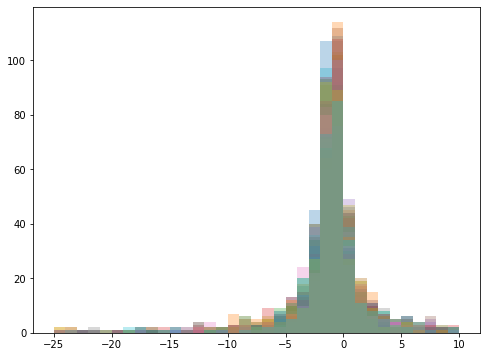

In [19]:
# plt.figure(figsize=(8,6))
# for iori in np.arange(nori):
#     plt.hist(adp_mag[:,iori], bins=np.linspace(-25,10,36), alpha=0.3)

In [18]:
mag = adp_mag.flatten('F')
ad = dfof_ad.flatten('F')
tg = dfof_tg.flatten('F')
stim = [np.arange(nori)] * adp_mag.shape[0]
stim_flat = np.sort([item for sublist in stim for item in sublist])
stim_flat.shape, mag.shape, ad.shape

((9720,), (9720,), (9720,))

In [20]:
df = pd.DataFrame({'stim':stim_flat, 'ad':ad, 'tg':tg, 'mag':mag, 'abs_mag':np.abs(mag)})
# df

,stim,ad,tg,mag,abs_mag
0,0,0.005857,-0.016957,-3.895013,3.895013
1,0,-0.006927,0.006891,-1.994792,1.994792
2,0,0.003783,-0.000537,-1.141878,1.141878
3,0,0.001768,0.009039,4.112705,4.112705
4,0,-0.000417,-0.007044,15.894562,15.894562
...,...,...,...,...,...
9715,29,0.022280,0.013207,-0.407244,0.407244
9716,29,-0.007709,-0.012219,0.585060,0.585060
9717,29,0.012647,0.002312,-0.817229,0.817229
9718,29,-0.010893,-0.001203,-0.889534,0.889534


In [21]:
mag_mean = df[['mag','stim']].groupby(['stim'], sort=False).mean().to_numpy().flatten()
mag_median = df[['mag','stim']].groupby(['stim'], sort=False).median().to_numpy().flatten()
mag_std = df[['mag','stim']].groupby(['stim'], sort=False).std().to_numpy().flatten()
mag_sem = df[['mag','stim']].groupby(['stim'], sort=False).sem().to_numpy().flatten()
# df[['mag','stim']].groupby(['stim'], sort=False).describe()

mag                                                            \
      count       mean          std           min       25%       50%   
stim                                                                    
0     324.0   0.349925    35.937711   -207.673233 -2.055781 -1.037130   
1     324.0  -0.022395    18.689697    -82.893670 -1.866568 -0.765955   
2     324.0   1.128308    24.143935    -66.205549 -1.698973 -0.924183   
3     324.0  -1.268877    11.238804    -90.538068 -2.059472 -1.096288   
4     324.0   0.359046    21.204332   -102.557359 -1.941418 -0.975214   
5     324.0  -1.038381    13.443255   -156.078648 -1.617745 -0.817689   
6     324.0  -6.363498   129.899613  -2278.903225 -2.191280 -0.960076   
7     324.0   0.162788    33.866164   -163.146232 -1.904200 -0.875474   
8     324.0  -2.650585    21.234717   -284.446901 -1.676721 -0.907702   
9     324.0   5.447402   108.015475    -78.971841 -1.937707 -1.094550   
10    324.0   2.474378    49.243886    -40.103865 -1.545610 -0.783385   
11    324.0  -0.668935    12.273097   -101.889385 -2.251951 -1.233059   
12    324.0  -1.236476    16.244827   -254.450271 -1.719468 -0.965997   
13    324.0  -1.180968     5.465040    -61.216575 -1.856130 -1.053169   
14    324.0  -1.493150    16.583208   -166.390235 -1.598176 -0.666145   
15    324.0  -1.651688    12.468870   -144.957460 -1.565324 -0.701641   
16    324.0  -2.136861    16.699417   -260.339812 -1.661042 -0.794894   
17    324.0 -64.973359  1130.661138 -20351.558829 -1.868903 -0.785208   
18    324.0  -1.134279     7.235184    -59.876297 -1.663129 -0.717285   
19    324.0  -1.687843    35.434013   -620.753550 -1.635765 -0.697112   
20    324.0   5.092153    86.318160    -61.811690 -1.996530 -1.175451   
21    324.0  -1.468322    13.643237   -187.008138 -1.704238 -0.789458   
22    324.0  -2.549404    20.748776   -267.118286 -2.061328 -0.948667   
23    324.0  -1.184426    14.971104   -200.150280 -1.793118 -0.846765   
24    324.0  -2.115686    11.767678   -112.956215 -2.097760 -1.078765   
25    324.0  -2.710392    34.256453   -592.400860 -1.983446 -0.857314   
26    324.0  -0.469695    16.048335    -81.593528 -1.622735 -0.759622   
27    324.0  -2.837901    17.107303   -192.616683 -1.618325 -0.821179   
28    324.0  -1.080912     4.221520    -35.031593 -1.875132 -0.990579   
29    324.0  -4.175771    32.988373   -504.539426 -2.163398 -1.031876   

                             
           75%          max  
stim                         
0     0.110152   548.404214  
1     0.181740   314.664977  
2     0.128274   388.548509  
3    -0.221157   112.153593  
4    -0.082806   305.448858  
5    -0.043591   116.325521  
6     0.136088   505.843054  
7     0.087739   573.991565  
8    -0.136771    76.682654  
9    -0.056018  1928.319692  
10    0.216192   875.111069  
11   -0.201788   107.359183  
12    0.123763    98.454673  
13    0.172805    17.735324  
14    0.219749   146.166148  
15    0.232440    53.502350  
16    0.061728    40.844848  
17   -0.102213    64.719335  
18    0.090296    74.962015  
19    0.229753    89.645705  
20   -0.282593  1179.176060  
21   -0.011633    64.591974  
22   -0.175148    51.381272  
23   -0.057716   112.053206  
24   -0.090902    27.485965  
25   -0.040001    61.008080  
26   -0.011571   162.156519  
27   -0.012871   109.075839  
28   -0.109059    31.553824  
29   -0.130584    22.155890

### adp_mag thresholding (todo: dfof_ad thresholding)

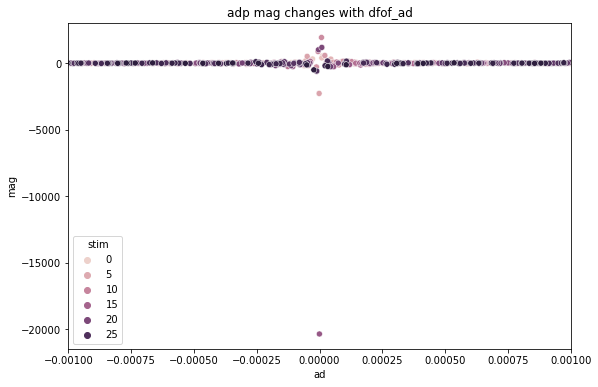

In [26]:
plt.figure(figsize=(9,6))
ax = sns.scatterplot(data=df, x="ad", y="mag", hue="stim")
plt.xlim([-0.001,0.001]);
ax.set(title = 'adp mag changes with dfof_ad');

cell selection: vis_ad only, with dfof_ad thresholding

0.45596707818930043

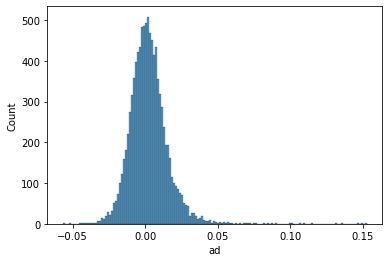

In [121]:
sns.histplot(data=df_th, x='ad');
sum(df_th.ad < 0) / len(df_th)

0.4704732510288066


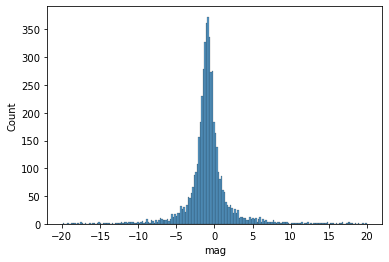

In [55]:
dfof_threshold = 0.00025
adp_threshold = 20 # 1, 2, 20

df_th = df.copy()
# df_th.loc[df_th[np.abs(df.ad) < dfof_threshold].index.to_numpy(),'mag'] = np.nan
df_th.loc[df_th[(df.ad) < dfof_threshold].index.to_numpy(),'mag'] = np.nan # not threshold by abs, bc 1-tail ttest originally?
df_th.loc[df_th[np.abs(df.mag) > adp_threshold].index.to_numpy(),'mag'] = np.nan
# bug / todo: fix vis_ad and filter normally by vis_ad, not filter by adp_mag

sns.histplot(data=df_th, x='mag');
print(df_th[np.isnan(df_th.mag)].shape[0] / df_th.shape[0])

### groupby bunnytop 3 groups

In [56]:
df_th['group'] = ''
df_th.loc[df_th.stim < 30, 'group'] = 'bottom'
df_th.loc[df_th.stim < 20, 'group'] = 'mid'
df_th.loc[df_th.stim < 10, 'group'] = 'top' # sorted by ascending adp, "top" adp imgs are the most adapted (lowest neg value)
df_th

,stim,ad,tg,mag,abs_mag,group
0,0,0.005857,-0.016957,-3.895013,3.895013,top
1,0,-0.006927,0.006891,NaN,1.994792,top
2,0,0.003783,-0.000537,-1.141878,1.141878,top
3,0,0.001768,0.009039,4.112705,4.112705,top
4,0,-0.000417,-0.007044,NaN,15.894562,top
...,...,...,...,...,...,...
9715,29,0.022280,0.013207,-0.407244,0.407244,bottom
9716,29,-0.007709,-0.012219,NaN,0.585060,bottom
9717,29,0.012647,0.002312,-0.817229,0.817229,bottom
9718,29,-0.010893,-0.001203,NaN,0.889534,bottom


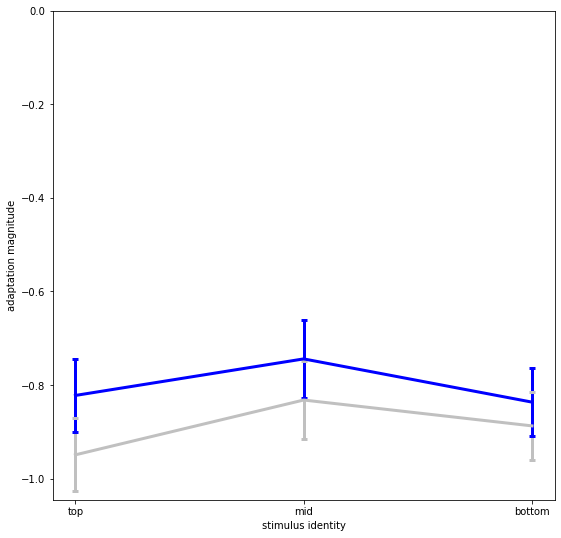

In [124]:
mag_mean = df_th[['mag','group']].groupby(['group'], sort=False).mean().to_numpy().flatten()
mag_median = df_th[['mag','group']].groupby(['group'], sort=False).median().to_numpy().flatten()
mag_std = df_th[['mag','group']].groupby(['group'], sort=False).std().to_numpy().flatten()
mag_sem = df_th[['mag','group']].groupby(['group'], sort=False).sem().to_numpy().flatten()

ngroup = len(np.unique(df_th.group))
plt.figure(figsize=(9,9))
plt.errorbar(np.arange(len(np.unique(df_th.group))), mag_median, yerr=mag_sem, zorder=100, 
             color='silver', linewidth=3, capsize=3, capthick=3);
plt.errorbar(np.arange(len(np.unique(df_th.group))), mag_mean, yerr=mag_sem, zorder=100, 
             color='blue', linewidth=3, capsize=3, capthick=3);
# sns.stripplot(x="group", y="mag", data=df_th);
plt.ylabel('adaptation magnitude');
plt.xlabel('stimulus identity');
plt.xticks([0,1,2], ['top','mid','bottom'])
# plt.ylim(-1.1,0)
plt.gca().set_ylim(top=0);

In [65]:
df_th[['mag','group']].groupby(['group'], sort=False).describe()

mag                                                               \
         count      mean       std        min       25%       50%       75%   
group                                                                         
top     1663.0 -0.822425  3.172725 -18.177904 -1.799577 -0.949335 -0.073269   
mid     1712.0 -0.744344  3.431418 -19.913654 -1.612681 -0.832212  0.072721   
bottom  1772.0 -0.836678  3.068876 -19.281336 -1.736600 -0.887461 -0.083812   

                   
              max  
group              
top     18.192877  
mid     19.996569  
bottom  17.616218

In [125]:
# mag_sort_id = mag_median.argsort()
# mag_median_sorted = mag_median[mag_sort_id[::-1]]
# mag_sem_sorted_med = mag_sem[mag_sort_id[::-1]]

# mag_sort_id = mag_mean.argsort()
# mag_mean_sorted = mag_mean[mag_sort_id[::-1]]
# mag_sem_sorted_mean = mag_sem[mag_sort_id[::-1]]

# mag_median_sorted[0], mag_median_sorted[-1], mag_mean_sorted[0], mag_mean_sorted[-1]

### one way anova btw 3 groups

In [106]:
from scipy.stats import f_oneway
f_oneway(df_th.loc[(df_th.group == 'top') & (~np.isnan(df_th.mag))].mag.to_numpy(),
         df_th.loc[(df_th.group == 'mid') & (~np.isnan(df_th.mag))].mag.to_numpy(),
         df_th.loc[(df_th.group == 'bottom') & (~np.isnan(df_th.mag))].mag.to_numpy())

F_onewayResult(statistic=0.40886145244278055, pvalue=0.6644278674883997)

## compare img order sorted by adp
### bunny500 vs bunnytop

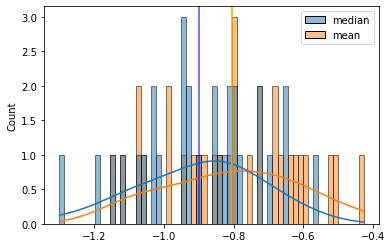

In [80]:
# compare adp median vs mean distribution among stims
data = {"median": df_th[['mag','stim']].groupby(['stim'], sort=False).median().squeeze(), 
        "mean": df_th[['mag','stim']].groupby(['stim'], sort=False).mean().squeeze()}
ax = sns.histplot(data, bins=60, kde=True)

plt.axvline(df_th[['mag','stim']].groupby(['stim'], sort=False).median().mean()[0], color='b', alpha=0.7)
plt.axvline(df_th[['mag','stim']].groupby(['stim'], sort=False).mean().mean()[0], color='orange');

In [81]:
# compare stim order sorted by median vs mean

stim_order_mean = df_th[['mag','stim']].groupby(['stim'], sort=False).mean().sort_values('mag').index.values
adp_mean = np.sort(mag_mean.copy())
stim_order_median = df_th[['mag','stim']].groupby(['stim'], sort=False).median().sort_values('mag').index.values
adp_median = np.sort(mag_median.copy())

seq_len = 10
set1 = set(stim_order_mean[:seq_len])
set2 = set(stim_order_median[:seq_len])
intersect_ratio = len(set1.intersection(set2)) / seq_len
print(intersect_ratio)

set1 = set(stim_order_mean[-seq_len:])
set2 = set(stim_order_median[-seq_len:])
intersect_ratio = len(set1.intersection(set2)) / seq_len
print(intersect_ratio)

intersect_ratio = 0
count = 0
for i in np.arange(10000):
    set1 = set(np.random.choice(nori, seq_len, replace=False)) # nori = nstim
    set2 = set(np.random.choice(nori, seq_len, replace=False))
    intersect_ratio = intersect_ratio + len(set1.intersection(set2)) / seq_len
    count = count + 1
intersect_ratio = intersect_ratio / count
print(intersect_ratio)

0.5
0.7
0.33477000000001605


In [82]:
stim_order_mean

array([29, 20,  4, 11, 23, 14,  7,  6,  3, 16, 22, 25,  0,  2,  9, 19,  8,
       21, 24, 17, 13, 28, 15, 26, 18,  1, 12, 27,  5, 10], dtype=int64)

In [84]:
np.arange(31)[1:]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

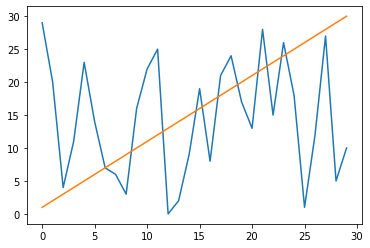

In [85]:
plt.plot(stim_order_mean)
plt.plot(np.arange(31)[1:])
# plt.plot(np.sort(stim_bottom))

### bunnytop sess1 vs 3

## Trace (cannot see bc no vis_ad filter)

In [87]:
trace.shape#, trace_mean.shape

(324, 30, 143)

In [88]:
trace_mean = np.mean(trace, axis=0)
trace_std = np.std(trace, axis=0)
trace_sem = trace_std / np.sqrt(trace.shape[0])

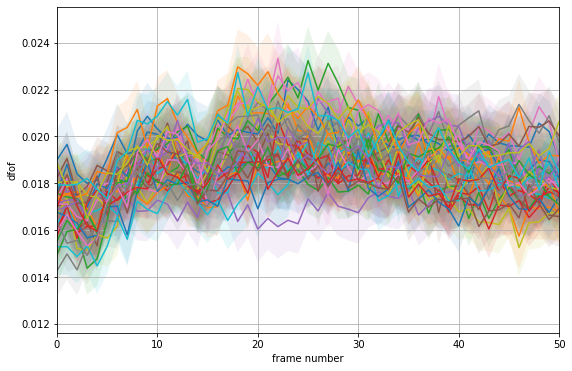

In [90]:
fig, ax = plt.subplots(figsize=(9,6))
for iori in np.arange(nori):
    ax.plot(np.arange(trace.shape[2]), trace_mean[iori,:].flatten(), )
#             color=sns.color_palette("bright")[iori])
    ax.fill_between(np.arange(trace.shape[2]), 
                    trace_mean[iori,:].flatten() + trace_sem[iori,:].flatten(), 
                    trace_mean[iori,:].flatten() - trace_sem[iori,:].flatten(),
                    alpha=0.1) # color=sns.color_palette("bright")[iori], 
plt.grid('minor')
plt.xlim(0, 50)
plt.xlabel('frame number')
plt.ylabel('dfof')
plt.show()

## Vis driven
### 1 way ANOVA

In [118]:
baseline = trace[:,:,:4]
baseline = np.mean(np.mean(baseline, 2),1)
baseline.shape

(324,)

In [111]:
dfof_ad.shape

(324, 30)